## ERDAP without erddapy example for ArcticHeat Alamo

** Plot PAR ** its in a seperate file, not on ERDDAP

In [2]:
%matplotlib inline

import xarray as xa
import netCDF4 as nc
import pandas as pd
import numpy as np
import urllib
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

/Volumes/WDC_internal/Users/bell/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
### Plot settings
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['axes.linewidth'] = 0.25
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 3.75
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 3.75
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1.75
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['svg.fonttype'] = 'none'

### connecting and basic information

In [4]:
### old way - Pre erddapy ###
cmap = cmocean.cm.solar
temp_filename = "data/9119.ptsPar.txt"

ALAMOID = "http://ferret.pmel.noaa.gov/alamo/erddap/tabledap/arctic_heat_alamo_profiles_9119"
cmap = cmocean.cm.thermal
temp_filename = "data/tmp.nc"

start_date="2017-09-16"
end_date  ="2017-12-12" 
urllib.urlretrieve(ALAMOID+".ncCFMA?profileid%2CFLOAT_SERIAL_NO%2CCYCLE_NUMBER%2CREFERENCE_DATE_TIME%2CJULD%2Ctime%2Clatitude%2Clongitude%2CPRES%2CTEMP%2CPSAL&time%3E="+start_date+"T23%3A52%3A00Z",temp_filename)

start_date_dt = datetime.datetime.strptime(start_date,"%Y-%m-%d"),
end_date_dt   = datetime.datetime.strptime(end_date,"%Y-%m-%d")

Preliminary PAR data was provided as a text file for ALAMO 9119

In [8]:
#datanc = nc.Dataset('data/tmp.nc') #using netcdf library
datapd = pd.read_csv('data/9119.ptsPar.txt',sep='\s+',names=['id','profile','pressure','temperature','salinity','PAR'])

dataxa = xa.open_dataset('data/tmp.nc')

In [65]:
def plot_PAR():
    depth_array = np.arange(0,55,0.25)
    temparray = np.ones((dataxa.dims['profile'],len(depth_array)))*np.nan
    ProfileTime = []
    cycle_col = 0

    plt.figure(1, figsize=(18, 3), facecolor='w', edgecolor='w')
    plt.subplot(1,1,1)
    ax1=plt.gca()
    
    for cycle in range(dataxa['profile'].min(),dataxa['profile'].max()+1,1):
        temp_time =  dataxa.time[cycle].data[~np.isnat(dataxa.time[cycle].data)]
        ProfileTime = ProfileTime + [temp_time]
        #remove where pressure may be unknown
        Pressure = dataxa.PRES[cycle].data[~np.isnan(dataxa.PRES[cycle].data)]
        try:
            Temperature = datapd.groupby('profile').get_group(int(dataxa.CYCLE_NUMBER[cycle][0].values)).PAR
        except:
            Temperature = Pressure * 0 + np.nan
        temparray[cycle_col,:] = np.interp(depth_array,np.flip(Pressure,axis=0),np.flip(Temperature,axis=0),
                                           left=np.nan,right=np.nan)
        cycle_col +=1

        ###plot black dots at sample points
        #plt.scatter(x=temp_time, y=Pressure,s=1,marker='.', edgecolors='none', c='k', zorder=3, alpha=1)
        ###plot colored dots at sample points with colorscheme based on  variable value
        plt.scatter(x=temp_time, y=Pressure,s=30,marker='.', edgecolors='none', c=np.log(Temperature+1.808), 
           vmin=0, vmax=10, cmap=cmocean.cm.solar, zorder=2)
    cbar = plt.colorbar()
    time_array = np.array([x[0] for x in ProfileTime])
    #plt.contourf(time_array,depth_array,np.log(temparray.T),extend='both',
    #    cmap=cmocean.cm.solar,levels=np.arange(0,10,1),alpha=0.9,zorder=1)
    
    
    #plt.contour(time_array,depth_array,temparray.T, colors='#d3d3d3',linewidths=1, alpha=1.0,zorder=3)
    
    ax1.invert_yaxis()
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax1.xaxis.set_major_locator(DayLocator(bymonthday=range(0,31,5)))
    ax1.xaxis.set_minor_locator(DayLocator(bymonthday=range(1,32,1)))
    ax1.xaxis.set_minor_formatter(DateFormatter(''))
    ax1.xaxis.set_major_formatter(DateFormatter('%d'))
    ax1.xaxis.set_tick_params(which='major', pad=25)
    ax1.xaxis.set_tick_params(which='minor', pad=5)
    ax1.set_xlim([start_date_dt,end_date_dt])
    ax1.set_ylim([50,0])

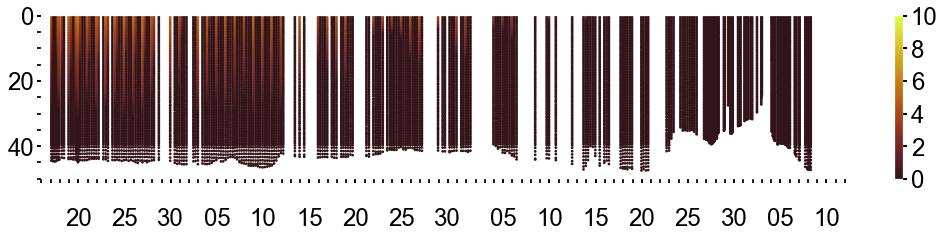

In [66]:
plot_PAR()